# GPyTorch Regression Tutorial

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from tqdm import trange

%matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2

Generate data

In [2]:
# generate cube
xs = torch.linspace(-1, 1, steps=11)
ys = torch.linspace(-1, 1, steps=11)
zs = torch.linspace(-1, 1, steps=11)

xp_face = torch.stack(torch.meshgrid(torch.ones(1), ys, zs), dim=-1).view(-1, 3)
xn_face = torch.stack(torch.meshgrid(-torch.ones(1), ys, zs), dim=-1).view(-1, 3)
yp_face = torch.stack(torch.meshgrid(xs, torch.ones(1), zs), dim=-1).view(-1, 3)
yn_face = torch.stack(torch.meshgrid(xs, -torch.ones(1), zs), dim=-1).view(-1, 3)
zp_face = torch.stack(torch.meshgrid(xs, ys, torch.ones(1)), dim=-1).view(-1, 3)
zn_face = torch.stack(torch.meshgrid(xs, ys, -torch.ones(1)), dim=-1).view(-1, 3)

cube = torch.cat(
  (xp_face, xn_face, yp_face, yn_face, zp_face, zn_face), dim=0) 
cube_noisy = torch.randn_like(cube) * 0.05 + cube
outer = cube * 1.5
inner = torch.zeros((1,3))

x_train = torch.cat((cube_noisy, outer, inner), dim=0)

f_train = torch.cat([
  torch.zeros(cube_noisy.shape[0]),
  torch.ones(outer.shape[0]),
  -torch.ones(inner.shape[0])
], dim=0)

/juno/u/chaoyi/miniconda3/envs/rl/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


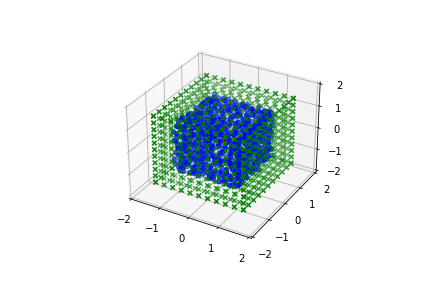

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.scatter(cube_noisy[:,0].numpy(), cube_noisy[:,1].numpy(), cube_noisy[:,2].numpy(), c='b', marker='o')
ax.scatter(inner[:,0].numpy(), inner[:,1].numpy(), inner[:,2].numpy(), c='r', marker='x')
ax.scatter(outer[:,0].numpy(), outer[:,1].numpy(), outer[:,2].numpy(),  c='g', marker='x')

Likelihood

In [4]:
class ThinPlateRegularizer(gpytorch.kernels.Kernel):
  # the sinc kernel is stationary
  is_stationary = True

  # We will register the parameter when initializing the kernel
  def __init__(self, dist_prior=None, dist_constraint=None, **kwargs):
    super().__init__(**kwargs)
    self.register_parameter(
      name='max_dist', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
    )
    if dist_constraint is None:
      dist_constraint = gpytorch.constraints.GreaterThan(0.20)
    self.register_constraint("max_dist", dist_constraint)
    if dist_prior is not None:
      self.register_prior(
        "dist_prior",
        dist_prior,
        lambda m: m.length,
        lambda m, v: m._set_length(v),
      )

  @property
  def maxdist(self):
    return self.raw_dist_constraint.transform(self.max_dist)

  @maxdist.setter
  def maxdist(self, value):
    return self._set_maxdist(value)

  def _set_maxdist(self, value):
    if not torch.is_tensor(value):
      value = torch.as_tensor(value).to(self.max_dist)
    self.initialize(max_dist=self.raw_dist_constraint.inverse_transform(value))

  # this is the kernel function
  def forward(self, x1, x2, **params):
    diff = self.covar_dist(x1, x2, **params)
    diff.where(diff == 0, torch.as_tensor(1e-20))
    noise = 1e-5
    white = noise*torch.eye(diff.shape[0], diff.shape[1])
    tp = 2*torch.pow(diff, 3)-3*self.max_dist * \
      torch.pow(diff, 2)+self.max_dist**3
    return white+tp

In [5]:
class thinPlateModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(thinPlateModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ZeroMean()
    self.covar_module = ThinPlateRegularizer()

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = thinPlateModel(x_train, f_train, likelihood)

In [7]:
hypers = {
  'likelihood.noise_covar.noise': torch.tensor(0.05),
  'covar_module.max_dist': torch.tensor(8.0),
}
model_params = model.initialize(**hypers)

train

In [8]:
training_iter = 10

In [9]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in (pbar := trange(training_iter)):
  # Zero gradients from previous iteration
  optimizer.zero_grad()
  # Output from model
  output = model(x_train)
  loss = -mll(output, f_train)
  loss.backward()
  pbar.set_description('Iter %d/%d - Loss: %.3f' % (
    i + 1, training_iter, loss.item(),
  ))
  optimizer.step()

Iter 10/10 - Loss: 0.466: 100%|██████████| 10/10 [00:01<00:00,  5.13it/s]


predict

In [10]:
resolusion = 100

In [11]:
model.eval()
likelihood.eval()

xs = torch.linspace(-1.5, 1.5, steps=resolusion + 1)
ys = torch.linspace(-1.5, 1.5, steps=resolusion + 1)
zs = torch.linspace(-1.5, 1.5, steps=resolusion + 1)
x_test = torch.stack(torch.meshgrid(xs, ys, zs), dim=-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
  f_test = likelihood(model(x_test.view(-1, 3)))
  
f_test_mu = f_test.mean.view(resolusion+1, resolusion+1, resolusion+1)

plot

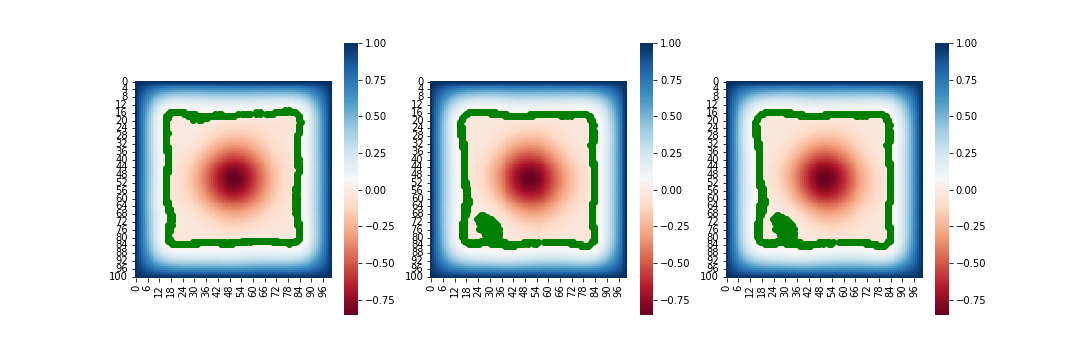

In [12]:
import numpy as np
import seaborn as sns
from matplotlib import cm

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

f_test_mu = torch.clip(f_test_mu, -1, 1)

pp = torch.linspace(0,resolusion,resolusion+1)
ii, jj = np.meshgrid(pp, pp)

f_test_z = f_test_mu[:,:,resolusion//2].numpy()
sns.heatmap(f_test_z, square=True,  cmap="RdBu", ax=axes[0])
mask = (np.abs(f_test_z) < 1e-2)
axes[0].scatter(ii[mask], jj[mask], color='g')

f_test_y = f_test_mu[:,resolusion//2,:].numpy()
ax = sns.heatmap(f_test_y, square=True,  cmap="RdBu", ax=axes[1])
mask = (np.abs(f_test_y) < 1e-2)
axes[1].scatter(ii[mask], jj[mask], color='g')

f_test_x = f_test_mu[:,resolusion//2,:].numpy()
ax = sns.heatmap(f_test_x, square=True,  cmap="RdBu", ax=axes[2])
mask = (np.abs(f_test_x) < 1e-2)
axes[2].scatter(ii[mask], jj[mask], color='g')

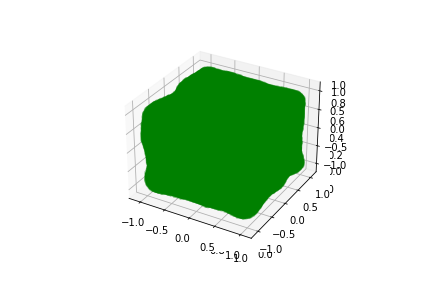

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
mask = (np.abs(f_test_mu) < 1e-2)
surface = x_test[mask,:]
ax = plt.axes(projection='3d')
ax.scatter(surface[:,0], surface[:,1], surface[:,2], c='g', alpha=0.3, linewidths=0.3)